In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape):
    """
    Builds a CNN model for predicting the 3D fractal dimension from 2D projections.

    Parameters:
    input_shape (tuple): Shape of the input tensor (e.g., (128, 128, 3)).

    Returns:
    tf.keras.Model: Compiled CNN model.
    """
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)  # Regression output
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [41]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
from PIL import Image

def parse_dataset(base_path, target_shape=(128, 128)):
    """
    Parses the dataset into input tensors and target values.

    Parameters:
    base_path (str): Path to the dataset folder.
    target_shape (tuple): Target shape (height, width) for resizing images.

    Returns:
    tuple: (input_tensors, target_values)
    """
    input_tensors = []
    target_values = []

    for folder in sorted(os.listdir(base_path)):
        folder_path = os.path.join(base_path, folder)

        # Skip non-directory entries (e.g., hidden files like .DS_Store)
        if not os.path.isdir(folder_path):
            continue

        try:
            # Load and resize images
            xy_img = img_to_array(load_img(
                os.path.join(folder_path, 'xy_projection.bmp'), 
                color_mode='grayscale'
            ).resize(target_shape)) / 255.0

            xz_img = img_to_array(load_img(
                os.path.join(folder_path, 'xz_projection.bmp'), 
                color_mode='grayscale'
            ).resize(target_shape)) / 255.0

            yz_img = img_to_array(load_img(
                os.path.join(folder_path, 'yz_projection.bmp'), 
                color_mode='grayscale'
            ).resize(target_shape)) / 255.0

            # Stack images as channels
            input_tensor = np.stack([xy_img.squeeze(), xz_img.squeeze(), yz_img.squeeze()], axis=-1)
            input_tensors.append(input_tensor)

            # Load target value
            with open(os.path.join(folder_path, 'correlation_dimension.txt'), 'r') as f:
                for line in f:
                    if "Correlation dimension" in line:
                        target_values.append(float(line.split(':')[-1]))

        except FileNotFoundError as e:
            print(f"Missing file in {folder_path}: {e}")
        except ValueError as e:
            print(f"Image shape mismatch in {folder_path}: {e}")

    return np.array(input_tensors), np.array(target_values)



# Load dataset
base_path = "/Volumes/PortableSSD/flocfractal/data/"
input_tensors, target_values = parse_dataset(base_path)

In [42]:
len(input_tensors)

10000

In [43]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(input_tensors, target_values, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [45]:
# Build model
input_shape = X_train.shape[1:]  # e.g., (128, 128, 3)
model = build_model(input_shape)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
250/250 [==============================] - 41s 163ms/step - loss: 0.5725 - mae: 0.2831 - val_loss: 0.0090 - val_mae: 0.0699
Epoch 2/5
250/250 [==============================] - 36s 144ms/step - loss: 0.0049 - mae: 0.0541 - val_loss: 0.0037 - val_mae: 0.0470
Epoch 3/5
250/250 [==============================] - 37s 147ms/step - loss: 0.0034 - mae: 0.0452 - val_loss: 0.0047 - val_mae: 0.0540
Epoch 4/5
250/250 [==============================] - 34s 137ms/step - loss: 0.0030 - mae: 0.0429 - val_loss: 0.0029 - val_mae: 0.0420
Epoch 5/5
250/250 [==============================] - 35s 139ms/step - loss: 0.0026 - mae: 0.0401 - val_loss: 0.0030 - val_mae: 0.0427


In [46]:
model.save("/Volumes/PortableSSD/flocfractal/floc.h5")

# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")


32/32 [==============================] - 1s 38ms/step - loss: 0.0033 - mae: 0.0461
Test Loss (MSE): 0.003320410382002592
Test MAE: 0.04611683636903763


In [47]:
# Predict on test set
y_pred = model.predict(X_test)

# Compare predictions with ground truth
for true, pred in zip(y_test[:10], y_pred[:10]):
    print(f"True: {true:.4f}, Predicted: {pred[0]:.4f}")


32/32 [==============================] - 1s 41ms/step
True: 2.3546, Predicted: 2.3311
True: 2.3539, Predicted: 2.3101
True: 2.4078, Predicted: 2.3738
True: 2.2445, Predicted: 2.2080
True: 1.7223, Predicted: 1.7717
True: 2.3001, Predicted: 2.3646
True: 2.4455, Predicted: 2.3796
True: 2.3071, Predicted: 2.2769
True: 1.8322, Predicted: 1.9405
True: 2.4475, Predicted: 2.4179


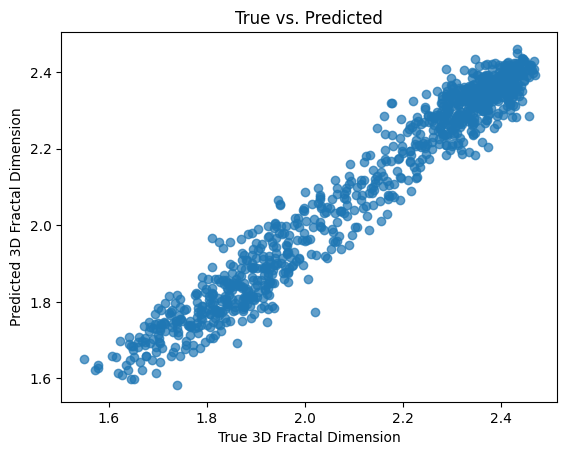

In [48]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("True 3D Fractal Dimension")
plt.ylabel("Predicted 3D Fractal Dimension")
plt.title("True vs. Predicted")
plt.show()

/Users/braydennoh/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


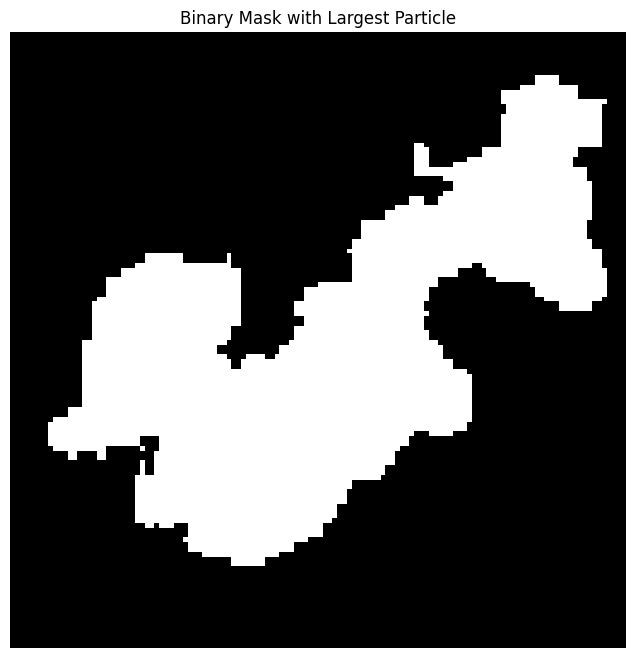

/Users/braydennoh/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1/1 [==============================] - 0s 37ms/step
Predicted Fractal Dimension: 2.0159


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.models import load_model

import cv2
import numpy as np
from sklearn.cluster import KMeans

def process_image_with_kmeans_largest(filepath, num_clusters=2, target_shape=(128, 128)):
    """
    Processes an image using KMeans clustering to generate a binary mask,
    keeps only the largest connected component (particle), and resizes it
    to match the CNN input shape with three channels.

    Parameters:
    filepath (str): Path to the BMP image.
    num_clusters (int): Number of clusters for KMeans. Default is 2 (background and particles).
    target_shape (tuple): Target shape for resizing the binary mask (height, width).

    Returns:
    np.ndarray: Processed binary mask tensor ready for CNN input with 3 channels.
    """
    # Read the image
    image = cv2.imread(filepath)
    if image is None:
        raise FileNotFoundError(f"Image not found: {filepath}")

    # Convert the image to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Reshape the image to a 2D array of pixels (for clustering)
    pixels = image_rgb.reshape((-1, 3))

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(pixels)

    # Identify the cluster with the lowest average intensity (darker background)
    cluster_averages = np.mean(kmeans.cluster_centers_, axis=1)
    darkest_cluster = np.argmin(cluster_averages)

    # Create a binary mask
    binary_mask = (kmeans.labels_.reshape(image_rgb.shape[:2]) != darkest_cluster).astype(np.uint8) * 255

    # Find connected components and keep only the largest one
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    if num_labels > 1:  # Exclude the background (label 0)
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Index of the largest particle
        binary_mask = (labels == largest_label).astype(np.uint8) * 255

    # Resize the binary mask to match the model's input shape
    binary_mask_resized = cv2.resize(binary_mask, target_shape, interpolation=cv2.INTER_NEAREST)

    # Normalize pixel values to [0, 1]
    normalized_mask = binary_mask_resized / 255.0

    # Stack the single-channel mask into 3 channels
    stacked_mask = np.stack([normalized_mask] * 3, axis=-1)

    # Add batch dimension
    processed_tensor = np.expand_dims(stacked_mask, axis=0)  # Add batch dimension

    return processed_tensor



def predict_fractal_dimension(filepath, model_path):
    """
    Predicts the fractal dimension of a given BMP image using a trained CNN model.

    Parameters:
    filepath (str): Path to the BMP image.
    model_path (str): Path to the saved CNN model.

    Returns:
    float: Predicted fractal dimension.
    """
    # Process the image to generate the binary mask tensor
    input_tensor = process_image_with_kmeans(filepath)

    # Load the trained model
    model = load_model(model_path)

    # Predict the fractal dimension
    predicted_dimension = model.predict(input_tensor)

    return predicted_dimension[0, 0]

# Example usage
model_path = "/Volumes/PortableSSD/flocfractal/floc.h5"

image_path = "/Users/braydennoh/Documents/testnew/cnn/flocgood/2622.bmp"
processed_tensor = process_image_with_kmeans_largest(image_path)

# Visualize the binary mask with only the largest particle
binary_mask = processed_tensor[0, :, :, 0]  # Extract the binary mask
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask with Largest Particle")
plt.axis('off')
plt.show()

predicted_dimension = predict_fractal_dimension(image_path, model_path)
print(f"Predicted Fractal Dimension: {predicted_dimension:.4f}")


In [16]:
import os
import numpy as np
from PIL import Image

def load_dataset(base_path, target_shape=(128, 128)):
    """
    Load the dataset from the specified path, preprocess images, and extract fractal dimensions.

    Parameters:
    base_path (str): Path to the dataset folders.
    target_shape (tuple): Target shape for resizing images.

    Returns:
    tuple: (input_tensors, target_values)
    """
    input_tensors = []
    target_values = []

    for folder in sorted(os.listdir(base_path)):
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue

        # Load the 3 BMP images
        try:
            images = []
            for axis in ['xy_projection.bmp', 'xz_projection.bmp', 'yz_projection.bmp']:
                image_path = os.path.join(folder_path, axis)
                img = Image.open(image_path).convert('L')  # Convert to grayscale
                img_resized = img.resize(target_shape)
                img_array = np.array(img_resized) / 255.0  # Normalize to [0, 1]
                images.append(img_array)
            
            # Stack images as channels (H, W, 3)
            stacked_images = np.stack(images, axis=-1)
            input_tensors.append(stacked_images)

            # Load fractal dimension from correlation_dimension.txt
            with open(os.path.join(folder_path, 'correlation_dimension.txt'), 'r') as f:
                for line in f:
                    if "Correlation dimension" in line:
                        target_values.append(float(line.split(':')[-1]))
        except Exception as e:
            print(f"Error processing folder {folder_path}: {e}")

    return np.array(input_tensors), np.array(target_values)

# Example usage
base_path = "/Volumes/PortableSSD/flocfractal/data1blurry/"
X, y = load_dataset(base_path)
print(f"Loaded dataset with {X.shape[0]} samples.")

Loaded dataset with 10000 samples.


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape):
    """
    Builds a CNN model for predicting the 3D fractal dimension.

    Parameters:
    input_shape (tuple): Shape of the input tensor (e.g., (128, 128, 3)).

    Returns:
    tf.keras.Model: Compiled CNN model.
    """
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)  # Regression output
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


Epoch 1/7
250/250 [==============================] - 34s 137ms/step - loss: 0.0770 - mae: 0.1308 - val_loss: 0.0077 - val_mae: 0.0707
Epoch 2/7
250/250 [==============================] - 35s 139ms/step - loss: 0.0053 - mae: 0.0572 - val_loss: 0.0099 - val_mae: 0.0829
Epoch 3/7
250/250 [==============================] - 35s 138ms/step - loss: 0.0048 - mae: 0.0546 - val_loss: 0.0042 - val_mae: 0.0534
Epoch 4/7
250/250 [==============================] - 34s 138ms/step - loss: 0.0036 - mae: 0.0473 - val_loss: 0.0036 - val_mae: 0.0484
Epoch 5/7
250/250 [==============================] - 35s 138ms/step - loss: 0.0034 - mae: 0.0458 - val_loss: 0.0025 - val_mae: 0.0389
Epoch 6/7
250/250 [==============================] - 35s 138ms/step - loss: 0.0030 - mae: 0.0426 - val_loss: 0.0031 - val_mae: 0.0429
Epoch 7/7
32/32 [==============================] - 1s 37ms/step - loss: 0.0027 - mae: 0.0423
Test Loss (MSE): 0.0027
Test MAE: 0.0423


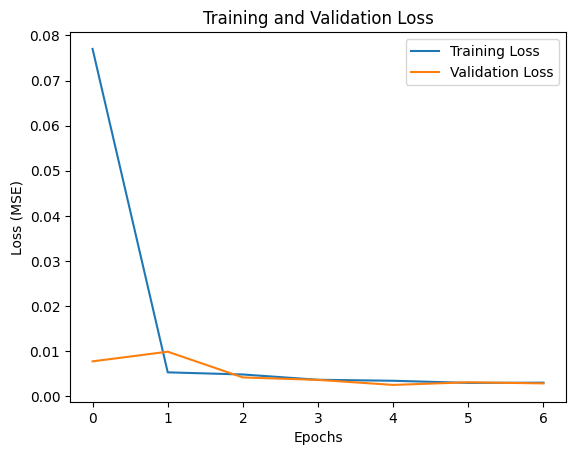

In [18]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build the CNN model
input_shape = X_train.shape[1:]  # e.g., (128, 128, 3)
model = build_cnn_model(input_shape)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=7,
    batch_size=32
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Save the trained model
model.save("/Volumes/PortableSSD/flocfractal/cnn_model_grayscale_blurry.h5")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

32/32 [==============================] - 1s 43ms/step


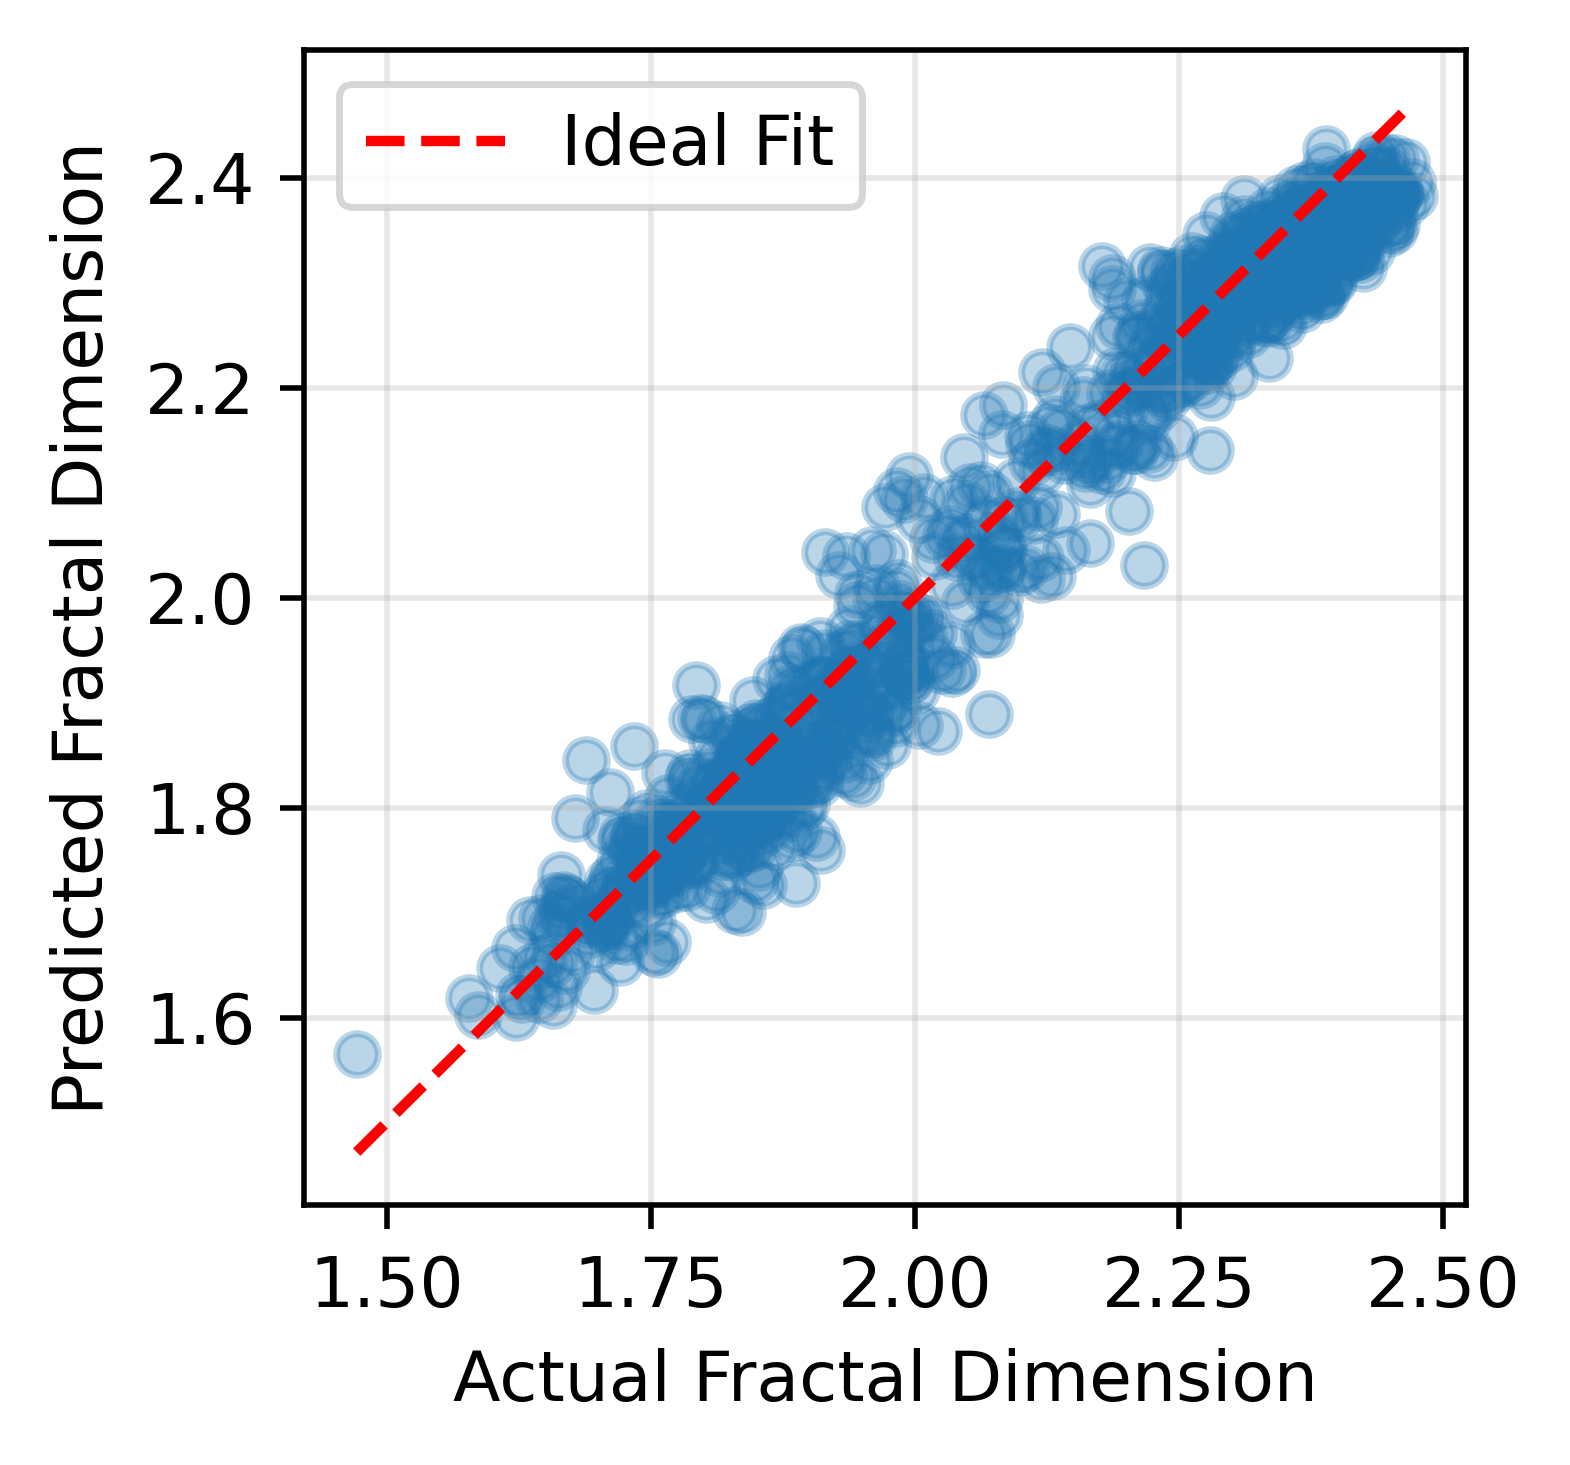

In [60]:
# Predict on the test set
y_pred = model.predict(X_test).flatten()

# Scatter plot of actual vs. predicted
plt.figure(figsize=(3,3))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Fractal Dimension')
plt.ylabel('Predicted Fractal Dimension')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [41]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

def process_grayscale_image(image_path, target_shape=(128, 128)):
    """
    Process a grayscale BMP image for input into the CNN model with 3 channels.

    Parameters:
    image_path (str): Path to the grayscale BMP image.
    target_shape (tuple): Target shape for resizing the image (height, width).

    Returns:
    np.ndarray: Processed image tensor ready for CNN input.
    """
    # Load the image in grayscale mode
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize the image to the target shape
    image_resized = image.resize(target_shape)

    # Normalize pixel values to [0, 1]
    image_array = np.array(image_resized) / 255.0
    
    # Stack the single grayscale channel into 3 identical channels
    stacked_image = np.stack([image_array] * 3, axis=-1)

    # Add batch dimension
    image_tensor = np.expand_dims(stacked_image, axis=0)  # Add batch dimension

    return image_tensor


def predict_fractal_dimension(image_path, model_path):
    """
    Predicts the fractal dimension of a given grayscale BMP image using a trained CNN model.

    Parameters:
    image_path (str): Path to the grayscale BMP image.
    model_path (str): Path to the saved CNN model.

    Returns:
    float: Predicted fractal dimension.
    """
    # Process the grayscale image
    input_tensor = process_grayscale_image(image_path)

    # Load the trained model
    model = load_model(model_path)

    # Predict the fractal dimension
    predicted_dimension = model.predict(input_tensor)

    return predicted_dimension[0, 0]

# Example usage
image_path = "/Volumes/PortableSSD/flocfractal/blurrytest/5.bmp"
model_path = "/Volumes/PortableSSD/flocfractal/cnn_model_grayscale.h5"

predicted_dimension = predict_fractal_dimension(image_path, model_path)
print(f"Predicted Fractal Dimension: {predicted_dimension:.4f}")

1/1 [==============================] - 0s 33ms/step
Predicted Fractal Dimension: 1.8875


In [22]:
from PIL import Image, ImageFilter
import os

# Define the input and output paths
input_path = '/Volumes/PortableSSD/flocfractal/blurrytest/1.bmp'
output_folder = '/Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Open the image
image = Image.open(input_path)

# Apply Gaussian blur incrementally and save each result as 2.bmp, 3.bmp, ...
for i, radius in enumerate(range(0, 11), start=2):  # Start numbering from 2.bmp
    # Apply Gaussian blur to the image
    blurred_image = image.filter(ImageFilter.GaussianBlur(radius=radius))
    
    # Save the blurred image
    output_path = os.path.join(output_folder, f'{i}.bmp')
    blurred_image.save(output_path)

    print(f'Saved: {output_path}')


Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/2.bmp
Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/3.bmp
Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/4.bmp
Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/5.bmp
Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/6.bmp
Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/7.bmp
Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/8.bmp
Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/9.bmp
Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/10.bmp
Saved: /Volumes/PortableSSD/flocfractal/blurrytest/blurred_images/11.bmp


In [36]:
import cv2
import numpy as np
from PIL import Image
from scipy.interpolate import interp1d
from sympy import symbols, solve

def capacity_dimension_3d(filename, ell):
    """
    Capacity Dimension 3D Function in Python
    Args:
        filename (str): Path to the grayscale image file
        ell (int): Desired resolution (must be larger than the original image size)

    Returns:
        d0_3D (float): Estimated 3D capacity dimension
    """
    # Load the grayscale image
    grayscale_image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # Convert to binary using Otsu's method
    _, binary_image = cv2.threshold(grayscale_image, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Check if ell is greater than the original image size
    if ell <= max(binary_image.shape):
        raise ValueError(f"Error: Desired resolution ell ({ell}) must be greater than the original image size ({max(binary_image.shape)}).")

    # Resize binary image to the desired resolution
    resized_image = cv2.resize(binary_image, (ell, ell), interpolation=cv2.INTER_NEAREST)

    # Dimensionless area of the aggregate (N_A)
    N_A = np.sum(resized_image == 1)

    # Dimensionless perimeter of the aggregate (N_P)
    perimeter = np.pad(resized_image, pad_width=1, mode='constant', constant_values=0)
    N_P = np.sum(perimeter[1:, :-1] != perimeter[:-1, :-1]) + np.sum(perimeter[:-1, 1:] != perimeter[:-1, :-1])

    # Outermost perimeter-based fractal dimension (dP_0)
    dP_0 = 2 * np.log10(N_P) / np.log10(N_A)

    # Perimeter-based fractal dimension at I=1
    Z = 2 * np.log10(4 * ell - 4) / np.log10(ell ** 2)

    # Alpha with \tilde{alpha}=4
    alpha = (4 - 2) * dP_0 / (Z - 2) + 2 * (Z - 4) / (Z - 2)

    # Analytical dP_I spectrum (dP_I = AI^2 + BI + C)
    A = -1 * alpha * (Z - dP_0) / (2 - alpha)
    B = Z - dP_0 - A
    C = dP_0

    # Check if the spectrum exceeds the global maximum = 2
    I_max = -1 * B / (2 * A)
    dP_I_max = A * I_max**2 + B * I_max + C

    if dP_I_max > 2:  # If dP_I_max exceeds 2
        tmpA = Z - dP_0
        tmpB = 2 * (dP_0 - 2)
        tmpC = 2 - dP_0

        discriminant = tmpB**2 - 4 * tmpA * tmpC
        if discriminant >= 0:
            tmpI = [
                (-tmpB + np.sqrt(discriminant)) / (2 * tmpA),
                (-tmpB - np.sqrt(discriminant)) / (2 * tmpA),
            ]
            tmpI_max = [i for i in tmpI if 0 < i < 1]
            if len(tmpI_max) > 0:
                tmpI_max = min(tmpI_max)
                A = (dP_0 - Z) / (2 * tmpI_max - 1)
                B = Z - dP_0 - A

    # Interpolation to find beta1, beta2, beta3
    ell_given = np.array([64, 128, 256, 512, 1024, 2048, 4096, 8192])
    beta1_given = np.array([3.1239, 4.1186, 5.0458, 6.1108, 7.5930, 10.4402, 13.7207, 16.4458])
    beta2_given = np.array([-9.7720, -12.4070, -14.8611, -17.6664, -21.6212, -29.3393, -38.0654, -44.7104])
    beta3_given = np.array([8.3318, 10.0342, 11.5941, 13.3657, 15.9176, 21.0255, 26.6887, 30.6337])

    beta1 = interp1d(ell_given, beta1_given, kind='linear')(ell)
    beta2 = interp1d(ell_given, beta2_given, kind='linear')(ell)
    beta3 = interp1d(ell_given, beta3_given, kind='linear')(ell)

    # Determine optimum perimeter-based fractal dimension (dP_I_opt)
    tmpdP_I_opt = symbols('tmpdP_I_opt')
    tmp_eq = A * (beta1 * tmpdP_I_opt**2 + beta2 * tmpdP_I_opt + beta3)**2 + \
             B * (beta1 * tmpdP_I_opt**2 + beta2 * tmpdP_I_opt + beta3) + \
             C - tmpdP_I_opt
    tmpdP_I_opt_solutions = solve(tmp_eq, tmpdP_I_opt)
    tmpdP_I_opt_real = [sol.evalf() for sol in tmpdP_I_opt_solutions if sol.is_real]

    tmpdP_I_opt_real = [dP for dP in tmpdP_I_opt_real if Z <= dP <= 2]
    if len(tmpdP_I_opt_real) == 0:  # No real solution
        dP_I_opt = A * I_max**2 + B * I_max + C
    else:
        dP_I_opt = max(tmpdP_I_opt_real)

    # 3D Capacity Dimension (d0_3D)
    k = Z * (Z - 1) + 1
    a = 9 * (Z - ((2 * k**2 - 9 * Z) / (k**2 - 9)))
    b = (2 * k**2 - 9 * Z) / (k**2 - 9)

    d0_3D = np.sqrt(float(a) / (float(dP_I_opt) - float(b)))  # Convert sympy objects to float
    return d0_3D


# Example usage
filename = '/Volumes/PortableSSD/flocfractal/blurrytest/5.bmp'
ell = 1024
d0_3D = capacity_dimension_3d(filename, ell)
print(f"3D Capacity Dimension: {d0_3D}")

3D Capacity Dimension: 2.0270288903872835


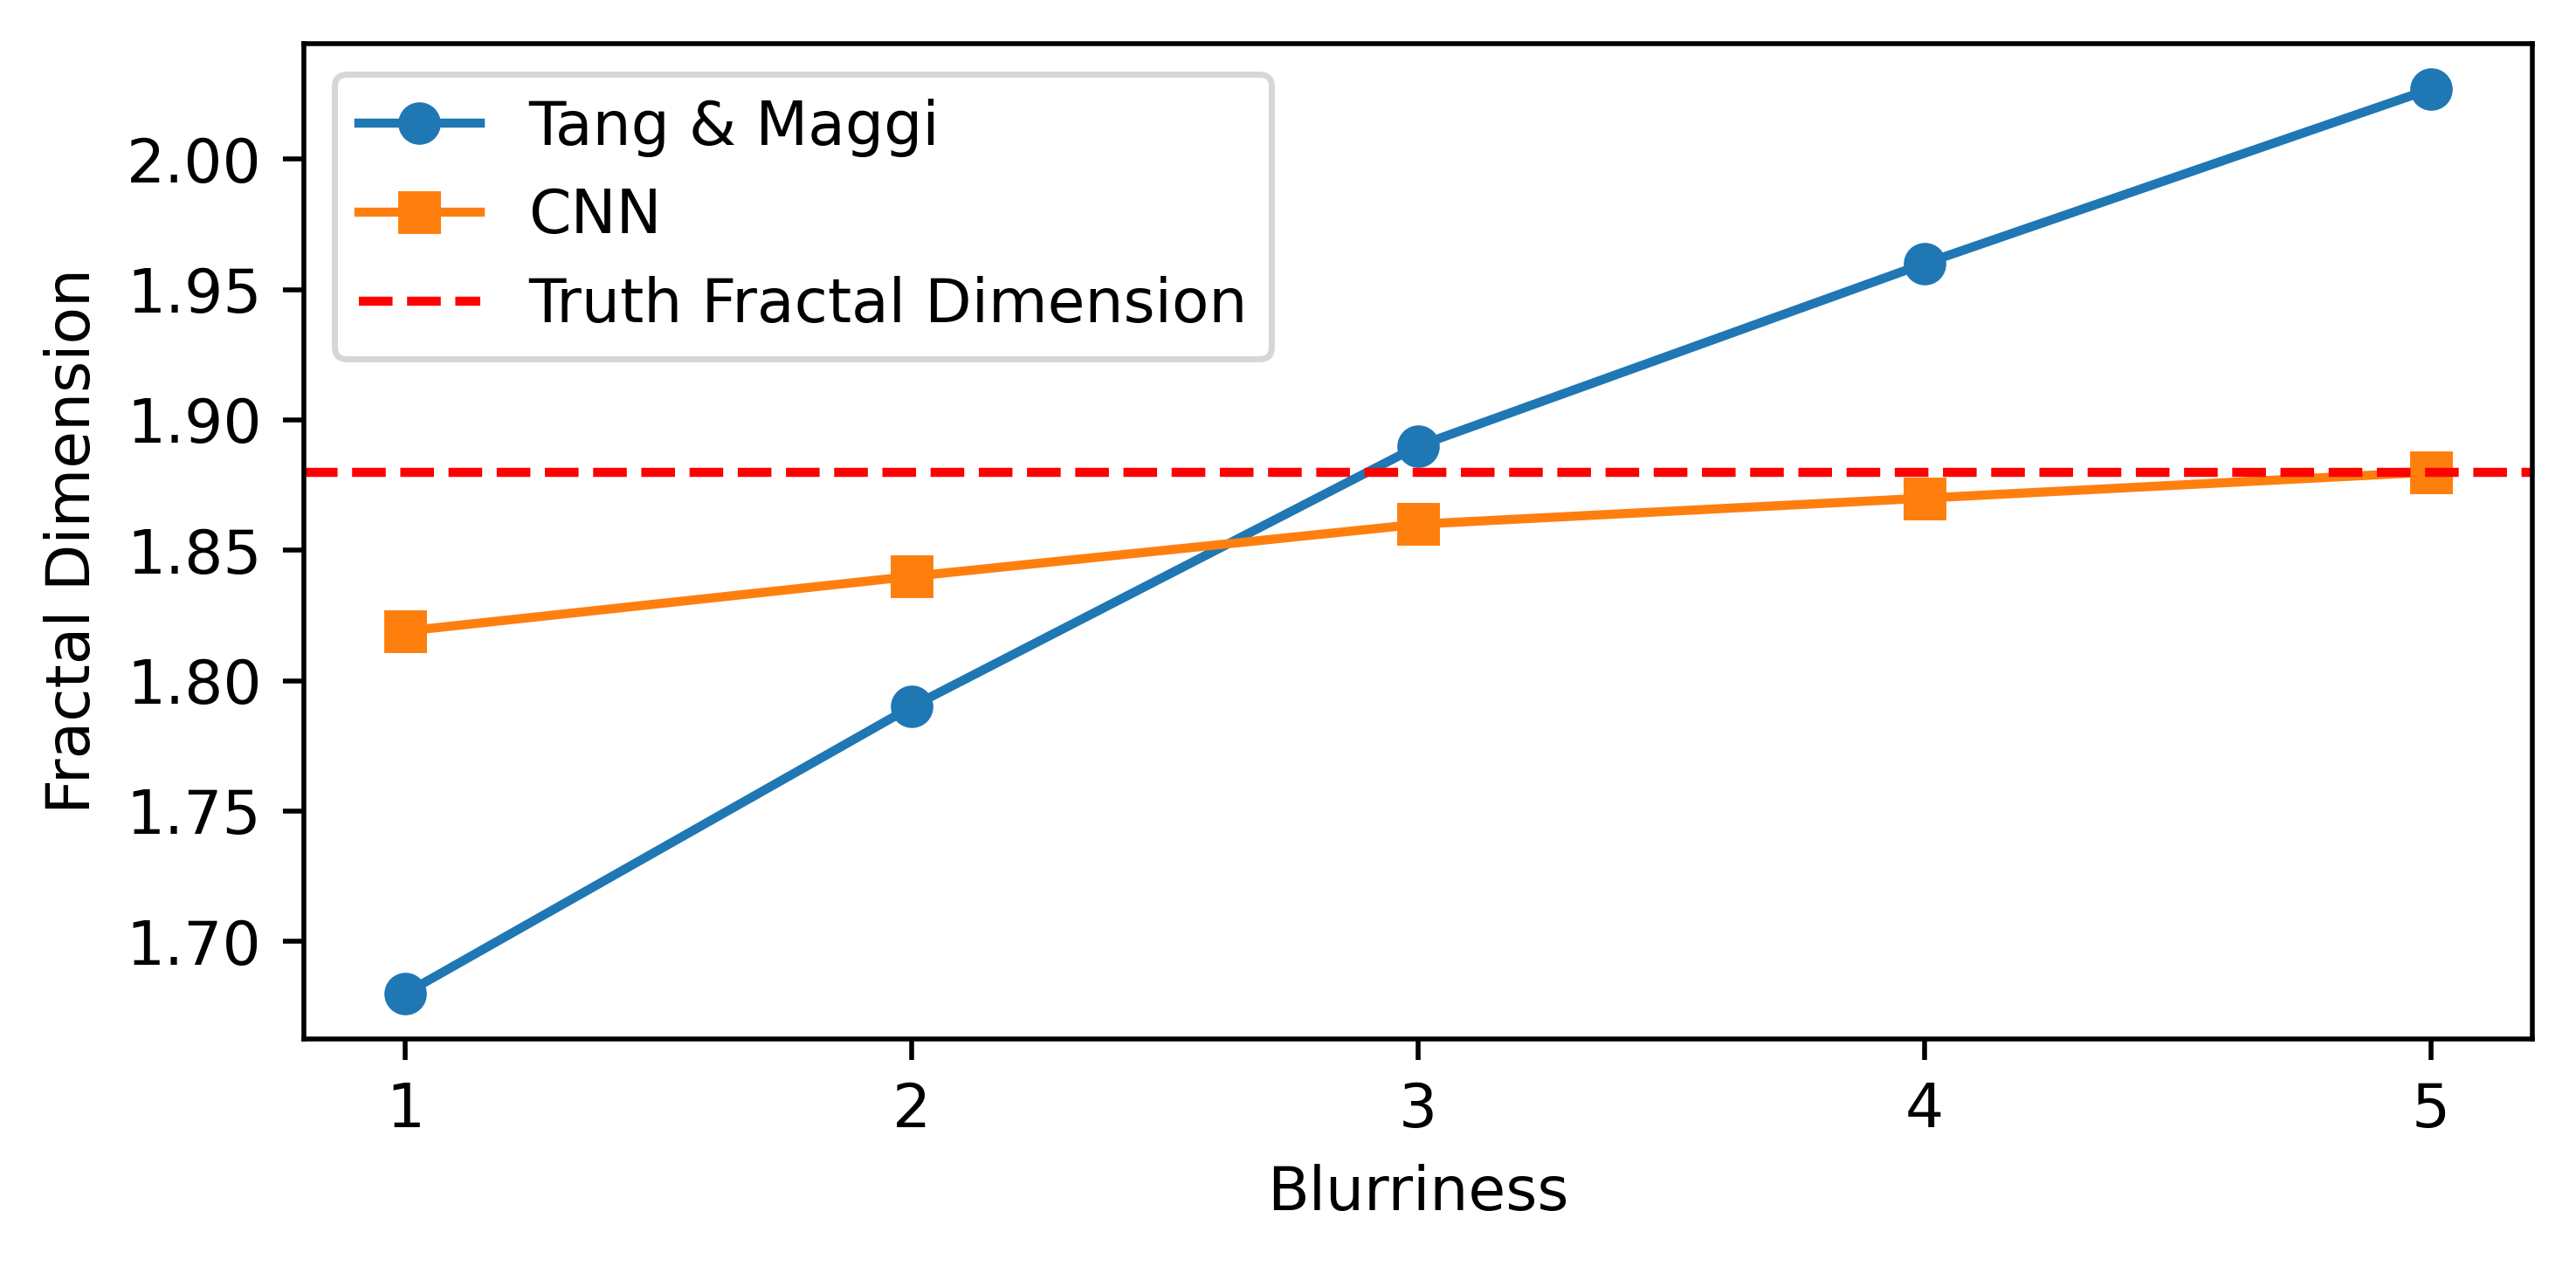

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the two lines
x_values = [1, 2, 3, 4, 5]
y1_values = [1.68, 1.79, 1.89, 1.96, 2.027]
y2_values = [1.819, 1.84, 1.86, 1.87, 1.88]

plt.figure(figsize=(6,3))

# Plot the lines
plt.plot(x_values, y1_values, label='Tang & Maggi', marker='o')  # First line
plt.plot(x_values, y2_values, label='CNN', marker='s')  # Second line

# Add a horizontal line at y = 1.88
plt.axhline(y=1.88, color='r', linestyle='--', label='Truth Fractal Dimension')  # Red dashed line

# Add labels and legend
plt.xlabel('Blurriness')
plt.ylabel('Fractal Dimension')
plt.xticks(np.arange(min(x_values), max(x_values)+1, 1))  # Set integer intervals on x-axis

# Place the legend outside the plot
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
